In [1]:
# Creating a solver for a 3D Bin Packing problem
# Each bin has a volume capacity and a weight capacity
import pandas as pd
import numpy as np



In [2]:
START_POSITION = [0, 0, 0]
rot_x0=np.array([
    [1,0,0],
    [0,1,0],
    [0,0,1]
]) #3,4,5

rot_x90=np.array([
    [1,0,0],
    [0,0,1],
    [0,1,0]
]) #3,5,4

rot_z90=np.array([
    [0,1,0],
    [1,0,0],
    [0,0,1]
]) #[4,3,5]


rot_y270_z270=np.array([
    [0,1,0],
    [0,0,1],
    [1,0,0]
])
#[4,5,3]

rot_x270_z90=np.array([
    [0,0,1],
    [1,0,0],
    [0,1,0]
]) #[5,3,4]


rot_y_90=np.array([
    [0,0,1],
    [0,1,0],
    [1,0,0]
])#[5,4,3]

rot_matrices = [rot_x0, rot_x90, rot_z90, rot_y270_z270, rot_x270_z90, rot_y_90]

def rect_intersect(item1, item2, n, m):
    #this code checks if two 3D objects intersect by projecting the objects onto three 
    #different 2D planes and checking if the resulting rectangles intersect on each plane. 
    #This method works because if two 3D objects intersect, then their projections onto 
    #any 2D plane must also intersect
    
    #returns true if rectangular faces intersect, false if they dont and its safe
    #Chosen axis n & m
    d1 = item1.get_dimension()
    d2 = item2.get_dimension()

    cx1 = item1.position[n] + d1[n]/2
    cy1 = item1.position[m] + d1[m]/2
    
    cx2 = item2.position[n] + d2[n]/2
    cy2 = item2.position[m] + d2[m]/2

    ix = abs(cx1-cx2)
    iy = abs(cy1-cy2)

    return ix < (d1[n]+d2[n])/2 and iy < (d1[m]+d2[m])/2

def intersect(item1, item2):
    #returns true if the items intersect
    return (
        rect_intersect(item1, item2, 0, 1) and
        rect_intersect(item1, item2, 1, 2) and
        rect_intersect(item1, item2, 0, 2)
    )


# length = x, width = y, height = z, facing forward, origin is back left of container
# units in mm to 1dp, kg
class Item:
    def __init__(self, ID, length, width, height , weight):
        self.ID = ID
        self.ori_dim = np.array([length, width, height])
        self.weight = weight
        self.volume = np.prod(self.ori_dim)
        self.rotation_type = 0
        self.position = START_POSITION
    
    def string(self):
        return print(f"Item {self.ID} - ({self.ori_dim[0]}mm x {self.ori_dim[1]}mm x {self.ori_dim[2]}mm, weight: {self.weight}kg, {self.volume}mm^3) pos({self.position}) rt({self.rotation_type}) ")

    def get_dimension(self):
        #include attribute error code
        return np.dot(rot_matrices[self.rotation_type],self.ori_dim)

class Bin:
    def __init__(self, ID, length, width, height, max_weight):
        self.ID = ID
        self.dim = np.array([length, width, height])
        self.max_weight = max_weight
        self.volume = np.prod(self.dim)
        self.items = []
        self.unfitted_items = []

    def string(self):
        return print(f"Bin {self.ID} - ({self.dim[0]}mm x {self.dim[1]}mm x {self.dim[2]}mm, max weight: {self.max_weight}kg, {self.volume}mm^3)")
    
    def get_total_weight(self):
        total_weight = 0
        return sum([x.weight for x in self.items])

    def put_item(self, item, pivot):
        fit = False
        valid_item_position = item.position
        item.position = pivot
        
        if self.get_total_weight() + item.weight > self.max_weight:
            return fit
        else:
            for i in range(0, 6):
                item.rotation_type = i
                dimension = item.get_dimension()
                if (
                    self.dim[0] < pivot[0] + dimension[0] or
                    self.dim[1] < pivot[1] + dimension[1] or
                    self.dim[2] < pivot[2] + dimension[2]
                ):
                    continue

                fit = True

                for current_item_in_bin in self.items:
                    if intersect(current_item_in_bin, item):
                        fit = False
                        break

                if fit:
                    self.items.append(item)

                if not fit:
                    item.position = valid_item_position

                return fit

        if not fit:
            item.position = valid_item_position

        return fit

class Packer:
    def __init__(self):
        self.bins = []
        self.items = []
        self.unfit_items = []
        self.total_items = 0   

    def add_bin(self, bin):
        return self.bins.append(bin)

    def add_item(self, item):
        self.total_items = len(self.items) + 1
        return self.items.append(item)

    def pack_to_bin(self, bin, item):
        fitted = False

        if not bin.items:
            response = bin.put_item(item, START_POSITION)

            if not response:
                bin.unfitted_items.append(item)

            return

        for axis in range(0, 3):
            items_in_bin = bin.items

            for ib in items_in_bin:
                pivot = [0, 0, 0]
                w, h, d = ib.get_dimension()
                if axis == 0:
                    pivot = [ib.position[0] + w,
                             ib.position[1],
                             ib.position[2]]
                elif axis == 1:
                    pivot = [
                        ib.position[0],
                        ib.position[1] + h,
                        ib.position[2]]
                elif axis == 2:
                    pivot = [ib.position[0],
                             ib.position[1],
                             ib.position[2] + d]

                if bin.put_item(item, pivot):
                    fitted = True
                    break
                
            if fitted:
                break

        if not fitted:
            bin.unfitted_items.append(item)

    def pack(self, bigger_first=False, distribute_items=False):

        self.bins.sort(key=lambda bin: bin.volume, reverse=bigger_first)
        self.items.sort(key=lambda item: item.volume, reverse=bigger_first)

        for bin in self.bins:
            for item in self.items:
                self.pack_to_bin(bin, item)

            if distribute_items:
                for item in bin.items:
                    self.items.remove(item)

In [22]:
packer = Packer()

#packer.add_bin(Bin('small-envelope', 11.5, 6.125, 0.25, 10))
#packer.add_bin(Bin('large-envelope', 15.0, 12.0, 0.75, 15))
#packer.add_bin(Bin('small-box', 8.625, 5.375, 1.625, 70.0))
#packer.add_bin(Bin('medium-box', 11.0, 8.5, 5.5, 70.0))
#packer.add_bin(Bin('medium-2-box', 13.625, 11.875, 3.375, 70.0))
#packer.add_bin(Bin('large-box', 12.0, 12.0, 5.5, 70.0))
packer.add_bin(Bin('large-2-box', 23.6875, 11.75, 4.0, 70.0))

packer.add_item(Item('50g [powder 1]', 3.9370, 1.9685, 1.9685, 1))
packer.add_item(Item('50g [powder 1]', 3.9370, 1.9685, 1.9685, 1))
#packer.add_item(Item('50g [powder 1]', 3.9370, 1.9685, 1.9685, 1))
'''
packer.add_item(Item('50g [powder 1]', 3.9370, 1.9685, 1.9685, 1))
packer.add_item(Item('50g [powder 1]', 3.9370, 1.9685, 1.9685, 1))
packer.add_item(Item('50g [powder 1]', 3.9370, 1.9685, 1.9685, 1))
packer.add_item(Item('50g [powder 1]', 3.9370, 1.9685, 1.9685, 1))
packer.add_item(Item('50g [powder 1]', 3.9370, 1.9685, 1.9685, 1))
packer.add_item(Item('50g [powder 1]', 3.9370, 1.9685, 1.9685, 1))
packer.add_item(Item('50g [powder 1]', 3.9370, 1.9685, 1.9685, 1))
'''
'''
packer.add_item(Item('50g [powder 2]', 3.9370, 1.9685, 1.9685, 2))
packer.add_item(Item('50g [powder 3]', 2, 2, 2, 3))
packer.add_item(Item('250g [powder 4]', 7.8740, 3.9370, 1.9685, 4))
packer.add_item(Item('250g [powder 5]', 7.8740, 3.9370, 1.9685, 5))
packer.add_item(Item('250g [powder 6]', 7.8740, 3.9370, 1.9685, 6))
packer.add_item(Item('250g [powder 7]', 7.8740, 3.9370, 1.9685, 7))
packer.add_item(Item('250g [powder 8]', 7.8740, 3.9370, 1.9685, 8))
packer.add_item(Item('250g [powder 9]', 7.8740, 3.9370, 1.9685, 9))
packer.add_item(Item('50g [powder 1]', 3.9370, 1.9685, 1.9685, 1))
packer.add_item(Item('50g [powder 2]', 3.9370, 1.9685, 1.9685, 2))
packer.add_item(Item('50g [powder 3]', 2, 2, 2, 3))
packer.add_item(Item('250g [powder 4]', 7.8740, 3.9370, 1.9685, 4))
'''

packer.pack()

for b in packer.bins:
    print(":::::::::::", b.string())

    print("FITTED ITEMS:")
    for item in b.items:
        print("====> ", item.string())

    print("UNFITTED ITEMS:")
    for item in b.unfitted_items:
        print("====> ", item.string())

    print("***************************************************")
    print("***************************************************")

Bin large-2-box - (23.6875mm x 11.75mm x 4.0mm, max weight: 70.0kg, 1113.3125mm^3)
::::::::::: None
FITTED ITEMS:
Item 50g [powder 1] - (3.937mm x 1.9685mm x 1.9685mm, weight: 1kg, 15.255844488249998mm^3) pos([0, 0, 0]) rt(0) 
====>  None
Item 50g [powder 1] - (3.937mm x 1.9685mm x 1.9685mm, weight: 1kg, 15.255844488249998mm^3) pos([3.937, 0, 0]) rt(0) 
====>  None
UNFITTED ITEMS:
***************************************************
***************************************************


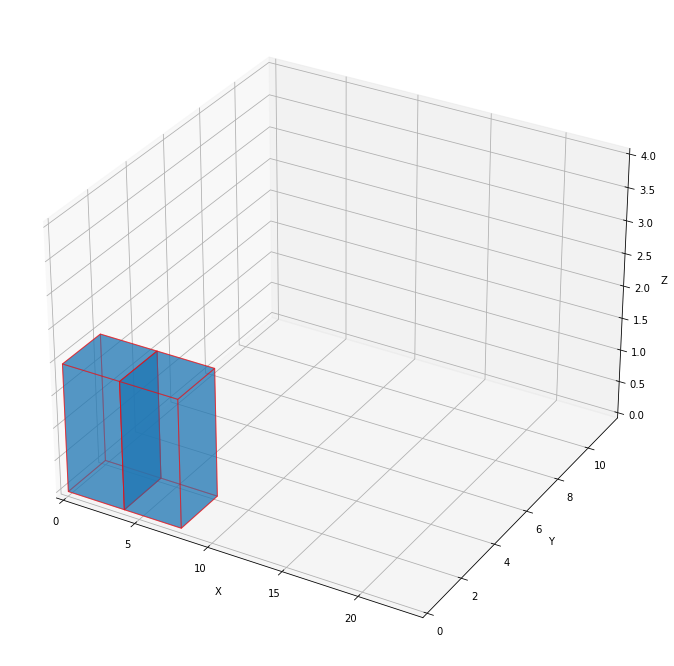

Item 50g [powder 1] - (3.937mm x 1.9685mm x 1.9685mm, weight: 1kg, 15.255844488249998mm^3) pos([0, 0, 0]) rt(0) 
None
Item 50g [powder 1] - (3.937mm x 1.9685mm x 1.9685mm, weight: 1kg, 15.255844488249998mm^3) pos([3.937, 0, 0]) rt(0) 
None


In [23]:
import random
import itertools
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

def draw_cube(ax, item):
    x, y, z = item.position
    dx, dy, dz = item.get_dimension()

    # Define the vertices of the cube
    vertices = np.array([[x, y, z],
                         [x+dx, y, z],
                         [x+dx, y+dy, z],
                         [x, y+dy, z],
                         [x, y, z+dz],
                         [x+dx, y, z+dz],
                         [x+dx, y+dy, z+dz],
                         [x, y+dy, z+dz]])

    # Define the faces of the cube
    faces = [[vertices[0], vertices[1], vertices[5], vertices[4]],
             [vertices[1], vertices[2], vertices[6], vertices[5]],
             [vertices[2], vertices[3], vertices[7], vertices[6]],
             [vertices[3], vertices[0], vertices[4], vertices[7]],
             [vertices[0], vertices[1], vertices[2], vertices[3]],
             [vertices[4], vertices[5], vertices[6], vertices[7]]]

    # Plot each face
    for face in faces:
        if dz==2:
            ax.add_collection3d(Poly3DCollection([face], alpha=0.5, edgecolor='y', linewidths=1))
        else:
            ax.add_collection3d(Poly3DCollection([face], alpha=0.5, edgecolor='r', linewidths=1))


def visualize_bin(bin):
    fig = plt.figure(figsize=(12,12 ))
    ax = fig.add_subplot(111, projection='3d')
    
    for item in bin.items:
        draw_cube(ax, item)
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    
    ax.set_xlim3d([0,bin.dim[0]])
    ax.set_ylim3d([0,bin.dim[1]])
    ax.set_zlim3d([0,bin.dim[2]])

    # Call the function to set equal aspect ratio
    #set_axes_equal(ax)
    #limits = [(0, bin.dim[0]), (0, bin.dim[1]), (0, bin.dim[2])]
    #set_axes_equal(ax, limits)
    
    plt.show()

def set_axes_equal(ax, limits):
    #'''Make axes of 3D plot have equal scale based on the given limits'''
    x_limits, y_limits, z_limits = limits
    
    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    # The plot bounding box is a sphere in the sense of the infinity
    # norm, hence call half the max range the plot radius.
    plot_radius = max([x_range, y_range, z_range])

    ax.set_xlim3d([0, x_middle + plot_radius])
    ax.set_ylim3d([0, y_middle + plot_radius])
    ax.set_zlim3d([0, z_middle + plot_radius])



# Call the visualization function
visualize_bin(packer.bins[0])
for item in packer.bins[0].items:
    print(item.string())